In [9]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

array([[143, 141, 141, ..., 144, 143, 141],
       [143, 142, 140, ..., 145, 143, 141],
       [143, 142, 140, ..., 145, 143, 142],
       ...,
       [167, 165, 164, ..., 169, 174, 166],
       [167, 165, 163, ..., 172, 176, 174],
       [164, 163, 161, ..., 174, 178, 181]], dtype=uint8)
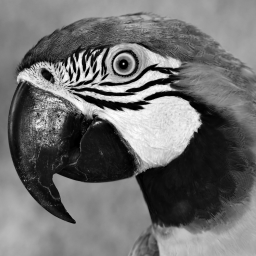

In [32]:
img = cv2.imread('parrot.png', cv2.IMREAD_GRAYSCALE)
img

array([[143, 141, 143, ..., 143, 143, 143],
       [143, 140, 142, ..., 145, 145, 143],
       [140, 140, 141, ..., 146, 146, 143],
       ...,
       [168, 165, 165, ..., 167, 170, 167],
       [167, 164, 163, ..., 168, 169, 168],
       [167, 163, 163, ..., 175, 170, 176]], dtype=uint8)
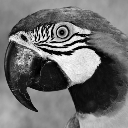

In [33]:
scale_factor = 2
img_downsampled = img[::scale_factor, ::scale_factor]
img_downsampled

In [34]:
blank_image = np.zeros((256, 256), dtype=np.uint8)

In [35]:
def Gaussian_kernel(pixel1,pixel2, omega):
  return np.exp(-((pixel1[0]-pixel2[0])**2+(pixel1[1]-pixel2[1])**2)/(2*omega**2))

In [36]:
def extract_p_time_p_squareSR(tuple_point, p, omega, img, img_downsampled):
  """
  Extracts p time p square around the point given by the tuple and computes the Gaussian kernel matrix that is p^2 x p^2.

  Args:
    tuple_point: A tuple representing the coordinates (x, y) of the point.
    p: The size of the square (p x p).
    omega: The value used for calculating the Gaussian kernel.

  Returns:
    - A list of tuples representing the coordinates within the p x p square
    around the given point
    - The p^2 x p^2 Gaussian kernel matrix (if the square is fully contained in the image)
    - The pixel_strength list (in the same order as the extracted pixels)
  """
  x, y = tuple_point
  extracted_points = []
  pixel_strengths =[]


  for i in range(x - p // 2, x + p // 2):
    for j in range(y - p // 2, y + p // 2):
      if 0 <= i < img.shape[0] and 0 <= j < img.shape[1] and i%2==0 and j%2==0:
        extracted_points.append((i, j))
        pixel_strengths.append(img_downsampled[int(i/2),int(j/2)])

  K=np.zeros((len(extracted_points),len(extracted_points)))
  for i in range(len(extracted_points)):
    for j in range(len(extracted_points)):
      K[i,j]=Gaussian_kernel(extracted_points[i],extracted_points[j],omega)
  return extracted_points, K, pixel_strengths

Best l: 0.05
Best omega: 2
Best SSIM: 0.8305151644996771


array([[132, 135, 137, ..., 136, 124,  99],
       [136, 139, 142, ..., 141, 127, 102],
       [138, 142, 145, ..., 145, 131, 104],
       ...,
       [159, 163, 165, ..., 168, 152, 123],
       [144, 147, 149, ..., 153, 139, 114],
       [116, 118, 119, ..., 125, 115,  93]], dtype=uint8)
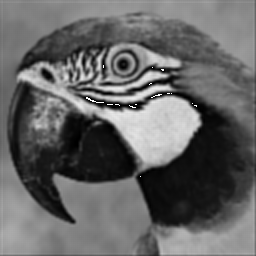

In [37]:
import itertools
p_size = 9
def optimize_hyperparameters(img, img_downsampled, l_values, omega_values):
    best_l = None
    best_omega = None
    best_ssim = -1

    for l, omega_value in itertools.product(l_values, omega_values):
        tester_img = img.copy()

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                extracted_points, K, pixel_strenths = extract_p_time_p_squareSR((i,j), p_size, omega_value, img, img_downsampled)
                alpha = np.matmul(np.linalg.inv(np.add(K,l*len(extracted_points)*np.identity(len(extracted_points)))),pixel_strenths)
                kernel = []
                for point in extracted_points:
                  kernel.append(Gaussian_kernel((i,j),point,omega_value))
                tester_img[i,j] = np.matmul(kernel,alpha)

        current_ssim = ssim(img, tester_img, data_range=img.max() - img.min())

        if current_ssim > best_ssim:
            best_ssim = current_ssim
            best_l = l
            best_omega = omega_value
            tester_img3 = tester_img.copy()

    return tester_img3, best_l, best_omega, best_ssim

#values
l_values = [0.01, 0.05, 0.1]
omega_values = [1, 2, 5]

tester_img3, best_l, best_omega, best_ssim = optimize_hyperparameters(img, img_downsampled, l_values, omega_values)

print(f"Best l: {best_l}")
print(f"Best omega: {best_omega}")
print(f"Best SSIM: {best_ssim}")
tester_img3

In [38]:
ssim_value = ssim(tester_img3, img, data_range=img.max() - img.min())
print(f"SSIM value is {ssim_value}")

SSIM value is 0.8305151644996771


In [39]:
psnr_value = psnr(tester_img3, img, data_range=img.max() - img.min())
print(f"PSNR value is {psnr_value}")

PSNR value is 21.671281678295887


array([[132, 135, 137, ..., 136, 124,  99],
       [136, 139, 142, ..., 141, 127, 102],
       [138, 142, 145, ..., 145, 131, 104],
       ...,
       [159, 163, 165, ..., 168, 152, 123],
       [144, 147, 149, ..., 153, 139, 114],
       [116, 118, 119, ..., 125, 115,  93]], dtype=uint8)
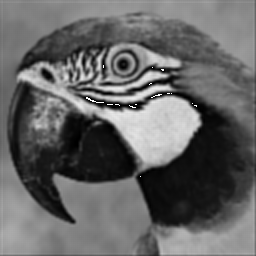

In [94]:
tester_img3

In [102]:
def extract_p_time_p_square(tuple_point, p, omega, unusual_pixels, tester_img3):
  """
  Extracts p time p square around the point given by the tuple and computes the Gaussian kernel matrix that is p^2 x p^2.

  Args:
    tuple_point: A tuple representing the coordinates (x, y) of the point.
    p: The size of the square (p x p).
    omega: The value used for calculating the Gaussian kernel.

  Returns:
    - A list of tuples representing the coordinates within the p x p square
    around the given point
    - The p^2 x p^2 Gaussian kernel matrix (if the square is fully contained in the image)
    - The pixel_strength list (in the same order as the extracted pixels)
    -noised pixels
  """
  x, y = tuple_point
  extracted_points = []
  pixel_strengths =[]


  for i in range(x - p // 2, x + p // 2 + 1):
    for j in range(y - p // 2, y + p // 2 + 1):
      if 0 <= i < tester_img3.shape[0] and 0 <= j < tester_img3.shape[1] and (i,j) not in unusual_pixels:
        extracted_points.append((i, j))
        pixel_strengths.append(tester_img3[i,j])

  K=np.zeros((len(extracted_points),len(extracted_points)))
  for i in range(len(extracted_points)):
    for j in range(len(extracted_points)):
      K[i,j]=Gaussian_kernel(extracted_points[i],extracted_points[j],omega)
  return extracted_points, K, pixel_strengths


In [145]:
threshold = 40
tester_img4 = tester_img3.copy()
p_size=4
l = 0.01
omega_value = 2
for i in range(12):
  unusual_pixels = []
  for r in range(1, tester_img4.shape[0] - 1):
      for c in range(1, tester_img4.shape[1] - 1):
        square = tester_img4[r-1:r+2, c-1:c+2]
        central_pixel = square[1, 1]
        average_intensity_excluding_central = (np.sum(square) - central_pixel) / 8
        if abs(central_pixel - average_intensity_excluding_central) > threshold:
            unusual_pixels.append((r, c))
  print(len(unusual_pixels))
  for i in range(tester_img4.shape[0]):
    for j in range(tester_img4.shape[1]):
      if (i,j) in unusual_pixels:
          extracted_points, K, pixel_strenths = extract_p_time_p_square((i,j), p_size, omega_value, unusual_pixels, tester_img4)
          alpha = np.matmul(np.linalg.inv(np.add(K,l*len(extracted_points)*np.identity(len(extracted_points)))),pixel_strenths)
          kernel = []
          for point in extracted_points:
              kernel.append(Gaussian_kernel((i,j),point,omega_value))
          tester_img4[i,j] = np.matmul(kernel,alpha)



285
111
23
3
0
0
0
0
0
0
0
0


array([[132, 135, 137, ..., 136, 124,  99],
       [136, 139, 142, ..., 141, 127, 102],
       [138, 142, 145, ..., 145, 131, 104],
       ...,
       [159, 163, 165, ..., 168, 152, 123],
       [144, 147, 149, ..., 153, 139, 114],
       [116, 118, 119, ..., 125, 115,  93]], dtype=uint8)
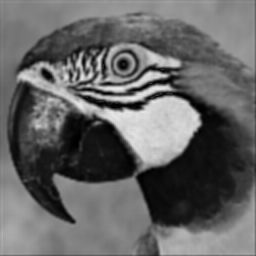

In [146]:
tester_img4

In [149]:
ssim_value = ssim(tester_img4, img, data_range=img.max() - img.min())
print(f"SSIM value is {ssim_value}")

SSIM value is 0.8362714673482454


In [150]:
psnr_value = psnr(tester_img4, img, data_range=img.max() - img.min())
print(f"PSNR value is {psnr_value}")

PSNR value is 22.4814014019045
